In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -U transformers huggingface fastai timm

In [2]:
from transformers import ConvNextImageProcessor, ConvNextForImageClassification
from helpers import *

set_seed(99, True)

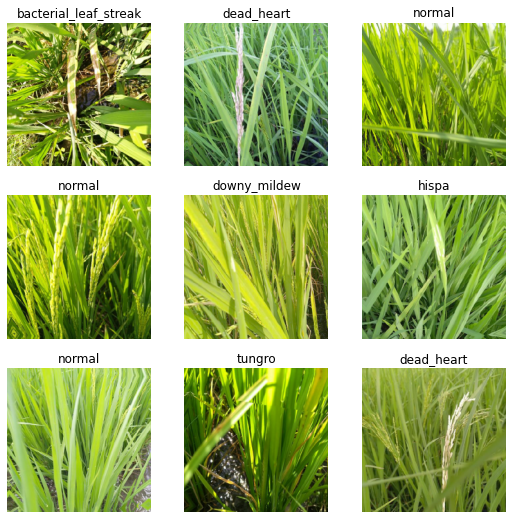

In [3]:
bs = 128
dls = get_image_dls(bs)
dls.show_batch()

# Get Hugging Face Vision Models

In [4]:
feature_extractor = ConvNextImageProcessor.from_pretrained("facebook/convnext-tiny-224")

def extract_features(x: torch.Tensor) -> torch.Tensor:
    if len(x.shape) == 4:
        return torch.cat([
            feature_extractor(x_i, return_tensors="pt")["pixel_values"]
            for x_i in x
        ], dim=0).cuda()
    return feature_extractor(x, return_tensors="pt")["pixel_values"].cuda()

In [5]:
class MyHFImageModel1(Module):
    def __init__(self, with_linear: bool = False, with_relu: bool = False):
        self.with_linear = with_linear
        self.with_relu = with_relu
        
        self.model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")
        
        linear = nn.Linear(1000, 10)
        if self.with_relu:
            self.linear = nn.Sequential(
                nn.ReLU(),
                linear,
            )
        else:
            self.linear = linear
        
    
    def forward(self, x):
        x = extract_features(x)
        x = self.model(x).logits
        if self.with_linear:
            x = self.linear(x)
        return x

In [8]:
def train_hf1_with_linear_head(with_linear: bool, with_relu: bool):
    learn = Learner(dls, MyHFImageModel1(with_linear, with_relu), metrics=[accuracy]).to_fp16()
    learn.model = learn.model.to(device)
    lr_steep, lr_valley = learn.lr_find(suggest_funcs=(steep, valley))
    print(lr_steep, lr_valley)
    lr = lr_steep * 0.95
    learn.fit_one_cycle(5, lr)

In [ ]:
with gpu_mem_restore_ctx():
    train_hf1_with_linear_head(with_linear=False, with_relu=False)

In [ ]:
with gpu_mem_restore_ctx():
    train_hf1_with_linear_head(with_linear=True, with_relu=False)

In [ ]:
with gpu_mem_restore_ctx():
    train_hf1_with_linear_head(with_linear=True, with_relu=True)

# Ensembled Model

In [5]:
class MyHFImageModel2(Module):
    def __init__(self, m1_weight: float = 0.5):
        self.model1 = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")
        self.linear = nn.Linear(1000, 10)
        self.model2 = vision_learner(dls, 'levit_256').model
        self.m1_weight = m1_weight
    
    def forward(self, x):
        x1 = self.model1(extract_features(x)).logits
        x1 = self.linear(x1)
        x2 = self.model2(x)
        
        return (x1 * self.m1_weight) + (x2 * (1 - self.m1_weight))
    
def hfimagemodel2_splitter(m):
    return (params(m.model1), params(m.model2), params(m.linear))

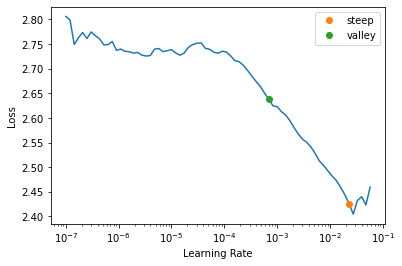

In [18]:
with gpu_mem_restore_ctx():
    learn2 = Learner(dls, MyHFImageModel2(), 
                     metrics=[accuracy], cbs=[ShowGraphCallback()],
                     splitter=hfimagemodel2_splitter)
    learn2.lr_find(suggest_funcs=(steep, valley))

In [7]:
lr = 8e-3

In [ ]:
with gpu_mem_restore_ctx():
    learn2 = Learner(dls, MyHFImageModel2(0.2), 
                     metrics=[accuracy], cbs=[ShowGraphCallback()],
                     splitter=hfimagemodel2_splitter)
    
    learn2.freeze_to(-1)
    learn2.fit_one_cycle(1, lr)
    
    learn2.unfreeze()
    learn2.fit_one_cycle(3, lr/2)

# Find best model weight

In [7]:
def train_hf2_with_weight(weight: float):
    learn3 = Learner(dls, MyHFImageModel2(weight), 
                         metrics=[accuracy], cbs=[ShowGraphCallback()],
                         splitter=hfimagemodel2_splitter).to_fp16()
        
    learn3.freeze_to(-1)
    learn3.fit_one_cycle(1, lr)

    learn3.unfreeze()
    learn3.fit_one_cycle(3, lr/2)
    
    return learn3

####### weight: 0.00 ########################################


epoch,train_loss,valid_loss,accuracy,time
0,3.144871,nan,0.200865,03:42


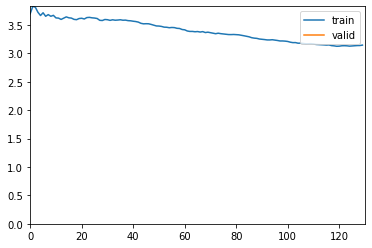

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [8]:
lr = 3e-3

weights = list(np.arange(0., 1.1, 0.1))

for weight in weights:
    with gpu_mem_restore_ctx():
        print(f'####### weight: {weight:.2f} ########################################')
        train_hf2_with_weight(weight)

In [ ]:
with gpu_mem_restore_ctx():
    train_hf2_with_weight(1.0)

# Try with no non-linearity before Linear layer. This means we're just doing a linear operation on the final outputs to squash them to (bs,10)

In [15]:
class MyHFImageModel3(Module):
    def __init__(self, m1_weight: float = 0.5):
        self.model1 = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")
        self.linear = nn.Linear(1000, 10)
        self.model2 = vision_learner(dls, 'levit_256').model
        self.m1_weight = m1_weight
    
    def forward(self, x):
        x1 = self.model1(extract_features(x)).logits
        x1 = self.linear(x1)
        x2 = self.model2(x)
        
        return (x1 * self.m1_weight) + (x2 * (1 - self.m1_weight))

In [16]:
with gpu_mem_restore_ctx():
    learn4 = Learner(dls, MyHFImageModel3(), 
                     metrics=[accuracy], cbs=[ShowGraphCallback()],
                     splitter=hfimagemodel2_splitter)
    learn4.lr_find(suggest_funcs=(steep, valley))

/usr/local/lib/python3.9/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


NameError: name 'hfimagemodel2_splitter' is not defined

In [21]:
lr = 1e-2

epoch,train_loss,valid_loss,accuracy,time
0,1.743578,1.583599,0.482941,02:09


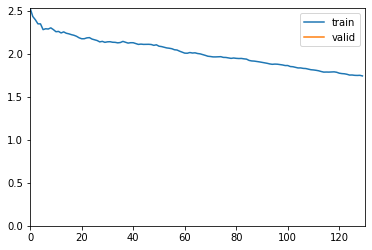

epoch,train_loss,valid_loss,accuracy,time
0,1.634771,1.452069,0.484863,02:53
1,1.149804,0.951784,0.699664,02:56
2,0.734884,0.540852,0.825084,02:53


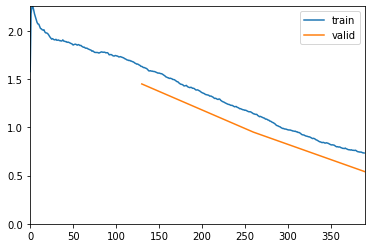

In [22]:
with gpu_mem_restore_ctx():
    learn4 = Learner(dls, MyHFImageModel3(0.8), 
                     metrics=[accuracy], cbs=[ShowGraphCallback()],
                     splitter=hfimagemodel2_splitter)
    
    learn4.freeze_to(-1)
    learn4.fit_one_cycle(1, lr)
    
    learn4.unfreeze()
    learn4.fit_one_cycle(3, lr)